Copyright (c) 2020-2021 Microsoft Corporation. All rights reserved. 

Licensed under the MIT License.

# Tune LightGBM with FLAML Library


## 1. Introduction

FLAML is a Python library (https://github.com/microsoft/FLAML) designed to automatically produce accurate machine learning models 
with low computational cost. It is fast and cheap. The simple and lightweight design makes it easy 
to use and extend, such as adding new learners. FLAML can 
- serve as an economical AutoML engine,
- be used as a fast hyperparameter tuning tool, or 
- be embedded in self-tuning software that requires low latency & resource in repetitive
   tuning tasks.

In this notebook, we demonstrate how to use FLAML library to tune hyperparameters of LightGBM with a regression example.

FLAML requires `Python>=3.6`. To run this notebook example, please install flaml with the `notebook` option:
```bash
pip install flaml[notebook]
```

In [ ]:
!pip install flaml[notebook];

## 2. Regression Example
### Load data and preprocess

Download [houses dataset](https://www.openml.org/d/537) from OpenML. The task is to predict median price of the house in the region based on demographic composition and a state of housing market in the region.

In [5]:
from flaml.data import load_openml_dataset
X_train, X_test, y_train, y_test = load_openml_dataset(dataset_id = 537, data_dir = './')

load dataset from ./openml_ds537.pkl
Dataset name: houses
X_train.shape: (15480, 8), y_train.shape: (15480,);
X_test.shape: (5160, 8), y_test.shape: (5160,)


### Run FLAML
In the FLAML automl run configuration, users can specify the task type, time budget, error metric, learner list, whether to subsample, resampling strategy type, and so on. All these arguments have default values which will be used if users do not provide them. 

In [6]:
''' import AutoML class from flaml package '''
from flaml import AutoML
automl = AutoML()

In [7]:
settings = {
    "time_budget": 120, # total running time in seconds
    "metric": 'r2', # primary metrics for regression can be chosen from: ['mae','mse','r2']
    "estimator_list": ['lgbm'], # list of ML learners; we tune lightgbm in this example
    "task": 'regression', # task type    
    "log_file_name": 'houses_experiment.log', # flaml log file
}

In [8]:
'''The main flaml automl API'''
automl.fit(X_train = X_train, y_train = y_train, **settings)

[flaml.automl: 02-22 14:37:41] {844} INFO - Evaluation method: cv
[flaml.automl: 02-22 14:37:41] {573} INFO - Using RepeatedKFold
[flaml.automl: 02-22 14:37:41] {865} INFO - Minimizing error metric: 1-r2
[flaml.automl: 02-22 14:37:41] {885} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl: 02-22 14:37:41] {944} INFO - iteration 0  current learner lgbm
[flaml.automl: 02-22 14:37:41] {1098} INFO -  at 0.2s,	best lgbm's error=0.7383,	best lgbm's error=0.7383
[flaml.automl: 02-22 14:37:41] {944} INFO - iteration 1  current learner lgbm
[flaml.automl: 02-22 14:37:41] {1098} INFO -  at 0.3s,	best lgbm's error=0.7383,	best lgbm's error=0.7383
[flaml.automl: 02-22 14:37:41] {944} INFO - iteration 2  current learner lgbm
[flaml.automl: 02-22 14:37:41] {1098} INFO -  at 0.4s,	best lgbm's error=0.4578,	best lgbm's error=0.4578
[flaml.automl: 02-22 14:37:41] {944} INFO - iteration 3  current learner lgbm
[flaml.automl: 02-22 14:37:41] {1098} INFO -  at 0.5s,	best lgbm's error=0.457

### Best model and metric

In [9]:
''' retrieve best config'''
print('Best hyperparmeter config:', automl.best_config)
print('Best r2 on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best hyperparmeter config: {'n_estimators': 451.0, 'max_leaves': 113.0, 'min_child_weight': 20.0, 'learning_rate': 0.025065630491840726, 'subsample': 1.0, 'log_max_bin': 8.0, 'colsample_bytree': 0.9046814915274195, 'reg_alpha': 8.352751749829367e-10, 'reg_lambda': 0.13991138691596908}
Best r2 on validation data: 0.8437
Training duration of best run: 17.86 s


In [10]:
automl.model

LGBMRegressor(colsample_bytree=0.9046814915274195,
              learning_rate=0.025065630491840726, max_bin=255,
              min_child_weight=20.0, n_estimators=451, num_leaves=113,
              objective='regression', reg_alpha=8.352751749829367e-10,
              reg_lambda=0.13991138691596908)

In [11]:
''' pickle and save the automl object '''
import pickle
with open('automl.pkl', 'wb') as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)

In [12]:
''' compute predictions of testing dataset ''' 
y_pred = automl.predict(X_test)
print('Predicted labels', y_pred)
print('True labels', y_test)

Predicted labels [147056.672508   246591.18821626 155253.69332074 ... 196516.76693923
 235571.37776252 270133.77185961]
True labels [136900. 241300. 200700. ... 160900. 227300. 265600.]


In [13]:
''' compute different metric values on testing dataset'''
from flaml.ml import sklearn_metric_loss_score
print('r2', '=', 1 - sklearn_metric_loss_score('r2', y_pred, y_test))
print('mse', '=', sklearn_metric_loss_score('mse', y_pred, y_test))
print('mae', '=', sklearn_metric_loss_score('mae', y_pred, y_test))

r2 = 0.8503723727607084
mse = 1977853769.4384706
mae = 29258.487121555943


In [14]:
from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, train_loss_history = \
    get_output_from_log(filename = settings['log_file_name'], time_budget = 60)

for config in config_history:
    print(config)

{'Current Learner': 'lgbm', 'Current Sample': 15480, 'Current Hyper-parameters': {'n_estimators': 4, 'max_leaves': 4, 'min_child_weight': 20.0, 'learning_rate': 0.1, 'subsample': 1.0, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 1e-10, 'reg_lambda': 1.0}, 'Best Learner': 'lgbm', 'Best Hyper-parameters': {'n_estimators': 4, 'max_leaves': 4, 'min_child_weight': 20.0, 'learning_rate': 0.1, 'subsample': 1.0, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 1e-10, 'reg_lambda': 1.0}}
{'Current Learner': 'lgbm', 'Current Sample': 15480, 'Current Hyper-parameters': {'n_estimators': 4.0, 'max_leaves': 4.0, 'min_child_weight': 20.0, 'learning_rate': 0.46335414315327306, 'subsample': 0.9339389930838808, 'log_max_bin': 10.0, 'colsample_bytree': 0.9904286645657556, 'reg_alpha': 2.841147337412889e-10, 'reg_lambda': 0.12000833497054482}, 'Best Learner': 'lgbm', 'Best Hyper-parameters': {'n_estimators': 4.0, 'max_leaves': 4.0, 'min_child_weight': 20.0, 'learning_rate': 0.46335414315

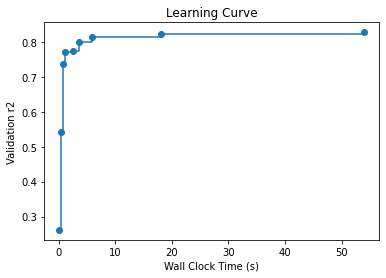

In [15]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation r2')
plt.scatter(time_history, 1-np.array(valid_loss_history))
plt.step(time_history, 1-np.array(best_valid_loss_history), where='post')
plt.show()

## 3. Comparison with alternatives

### FLAML's accuracy

In [16]:
print('flaml r2', '=', 1 - sklearn_metric_loss_score('r2', y_pred, y_test))

flaml r2 = 0.8503723727607084


### Default LightGBM

In [17]:
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor()

In [18]:
lgbm.fit(X_train, y_train)

LGBMRegressor()

In [19]:
y_pred = lgbm.predict(X_test)
from flaml.ml import sklearn_metric_loss_score
print('default lgbm r2', '=', 1 - sklearn_metric_loss_score('r2', y_pred, y_test))

default lgbm r2 = 0.8296179648694404


### Optuna LightGBM Tuner

In [ ]:
!pip install optuna==2.5.0;

In [21]:
from sklearn.model_selection import train_test_split
train_x, val_x, train_y, val_y = train_test_split(X_train, y_train, test_size=0.1)
import optuna.integration.lightgbm as lgb
dtrain = lgb.Dataset(train_x, label=train_y)
dval = lgb.Dataset(val_x, label=val_y)
params = {
    "objective": "regression",
    "metric": "regression",
    "verbosity": -1,
}


In [22]:
%%time
model = lgb.train(params, dtrain, valid_sets=[dtrain, dval], verbose_eval=10000)        


875128.6166067 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 2131729337.83384.
bagging, val_score: 1949307059.499325: 100%|##########| 10/10 [00:27<00:00,  2.73s/it]
feature_fraction_stage2, val_score: 1949307059.499325:  17%|#6        | 1/6 [00:02<00:11,  2.20s/it][I 2021-02-22 14:42:05,220] Trial 37 finished with value: 1949307059.499325 and parameters: {'feature_fraction': 0.9159999999999999}. Best is trial 37 with value: 1949307059.499325.
feature_fraction_stage2, val_score: 1949307059.499325:  33%|###3      | 2/6 [00:04<00:08,  2.16s/it][I 2021-02-22 14:42:07,344] Trial 38 finished with value: 1949307059.499325 and parameters: {'feature_fraction': 0.8839999999999999}. Best is trial 37 with value: 1949307059.499325.
feature_fraction_stage2, val_score: 1949307059.499325:  50%|#####     | 3/6 [00:06<00:06,  2.30s/it][I 2021-02-22 14:42:09,820] Trial 39 finished with value: 1988181425.985298 and parameters: {'feature_fraction': 0.948}. Best is trial 37 with va

In [23]:
y_pred = model.predict(X_test)
from flaml.ml import sklearn_metric_loss_score
print('Optuna LightGBM Tuner r2', '=', 1 - sklearn_metric_loss_score('r2', y_pred, y_test))

Optuna LightGBM Tuner r2 = 0.8476245395516778
